# Ontology Enhanced PCA Model Final

### Importing Required Libraries for ESG PCA Analysis

This cell imports libraries for data manipulation (Pandas, NumPy), visualization (Matplotlib, Seaborn), PCA and imputation (scikit-learn), SPARQL querying, and clustering analysis.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from SPARQLWrapper import SPARQLWrapper, JSON

### Querying ESG Knowledge Graph for the given metrics

This code connects to the GraphDB repository and executes a SPARQL query to retrieve ESG observations filtered based on metric, year and pillar for the respective industry.

In [3]:
"""
Parameters:
endpoint (str): Base URL of the GraphDB server (e.g., "http://localhost:7200").
repository (str): GraphDB repository name (e.g., "PCA_Ontology").
industry (str, optional): ESG industry filter (e.g., "semiconductors").
metric_filter (str, optional): Substring to match in metric name.
pillar_filter (str, optional): Pillar value to filter on.
year (str, optional): Year to filter.

Returns:
dict: SPARQL query results in JSON format.
"""

def query_esg_observations( endpoint, repository, industry, metric_filter, pillar_filter, year):

    sparql = SPARQLWrapper(f"{endpoint}/repositories/{repository}")

    query = """
    PREFIX ex: <http://example.org/esg#>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

    SELECT DISTINCT ?company ?year ?metric ?category ?value ?pillar ?unit ?model 
    WHERE {
      ?obs a ex:ESGObservation ;
           ex:hasCompany ?company ;
           ex:hasYear ?year ;
           ex:hasMetric ?metric ;
           ex:hasCategory ?category ;
           ex:hasValue ?value ;
           ex:hasPillar ?pillar ;
           ex:hasUnit ?unit .
    """

    if industry:
        query += f"      ?obs ex:belongsToIndustry ex:{industry} .\n" 
    
    query += "      ?model ex:relatedToMetric ?metric .\n"
    
    if metric_filter:
        query += f'      FILTER(CONTAINS(STR(?metric), "{metric_filter}"))\n'
    if pillar_filter:
        query += f'      FILTER(STRAFTER(STR(?pillar), "#") = "{pillar_filter}")\n'
    if year:
        query += f'      FILTER(?year = "{year}"^^xsd:gYear)\n'

    query += "    } ORDER BY ?company ?year ?metric"

    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

### Converting SPARQL Results to Structured Records

This block processes SPARQL query results into a list of structured records by extracting and cleaning fields like metric name, industry, category, and values for further analysis.


In [4]:
"""
Parameters:
results (dict): SPARQL query result in JSON format.
Returns:
List[Dict]: List of records with keys like company, year, metric, industry, etc.
"""

def parse_esg_results(results):
    records = []

    for result in results["results"]["bindings"]:
        # Extract full metric name
        metric_full = result["metric"]["value"].split("#")[-1]

        # split metric into metric_name and industry
        if "_" in metric_full:
            metric_parts = metric_full.rsplit("_", 1)
            metric_name = metric_parts[0]
            industry = metric_parts[1]
        else:
            metric_name = metric_full
            industry = "Unknown"

        record = {
            "company": result["company"]["value"].split("#")[-1],
            "year": result["year"]["value"],
            "metric": metric_name,
            "industry": industry,
            "category": result["category"]["value"].split("#")[-1],
            "value": float(result["value"]["value"]),
            "pillar": result["pillar"]["value"].split("#")[-1],
            "unit": result["unit"]["value"],
            "model": result["model"]["value"].split("#")[-1]
        }
        records.append(record)

    return records


### Preparing Pivot Table for PCA Input

Defines a function to filter ESG records by model name and transform them into a pivot table format with companies as rows and ESG categories as columns, removing columns with excessive missing data.


In [5]:
"""
Parameters:
records (list): List of ESG records (dicts).
model_name (str): The model name to filter on (e.g., 'ghg_emissions_model').
missing_threshold (float): Maximum allowed missing value ratio per column (0.9 = 90%).

Returns:
pd.DataFrame: Filtered pivot table with categories as columns and companies as rows.
"""

def prepare_pivot_table(records, model_name, missing_threshold):

    # Convert to DataFrame
    df = pd.DataFrame(records)
    # Filter for the given model
    filtered_df = df[df['model'] == model_name]
    # Pivot: companies as rows, categories as columns
    pivot_df = filtered_df.pivot_table(
        index='company',
        columns='category',
        values='value',
        aggfunc='sum'
    )
    # Drop columns with >threshold missing
    missing_ratio = pivot_df.isna().mean()
    pivot_df_filtered = pivot_df.loc[:, missing_ratio < missing_threshold]

    return pivot_df_filtered

### Imputing Missing Values Based on Data Characteristics

Defines a function to automatically select and apply the best imputation method (mean, median, or KNN) based on the overall skewness and missingness in the DataFrame.


In [6]:
"""
Parameters:
df (pd.DataFrame): The input DataFrame with missing values to impute.
n_neighbors (int): Number of neighbors for KNN imputation (default: 5).

Returns:
pd.DataFrame: Imputed DataFrame with missing values filled using the selected method.

Method Selection Logic:
- Mean imputation: if missing < 10% and skewness < 1
- Median imputation: if missing < 30%
- KNN imputation: otherwise (e.g., high missingness or skew)
"""

def select_best_imputation(df, n_neighbors):
    skew = df.skew().abs().mean()
    missing_value = df.isna().mean().mean()

    if missing_value < 0.1 and skew < 1:
        print("→ Using mean imputation (low skew & low missing values)")
        return df.fillna(df.mean())
    elif missing_value < 0.3:
        print("→ Using median imputation (moderate missing values or skew)")
        return df.fillna(df.median())
    else:
        print("→ Using KNN imputation (high missing values)")
        knn_imputer = KNNImputer(n_neighbors=n_neighbors)
        knn_imputed = knn_imputer.fit_transform(df)
        return pd.DataFrame(knn_imputed, index=df.index, columns=df.columns)

### Running PCA on Scaled ESG Data

This function standardizes the input data and applies PCA to extract the top 4 principal components, returning both the PCA object and the transformed scores.


In [43]:
"""
Parameters:
df (pd.DataFrame): Input data with numerical features.
Returns:
tuple: (PCA object, PCA scores as ndarray)
"""
def run_pca(df):
    scaled = StandardScaler().fit_transform(df)
    pca = PCA(n_components=4)
    scores = pca.fit_transform(scaled)
    return pca, scores

### Complete PCA Workflow with Imputation

This function performs missing value imputation followed by PCA, returning the PCA model, scores, and the imputed dataset for downstream analysis.


In [8]:
""" 
Parameters:
pivot table (pd.DataFrame): Filtered pivot table with categories as columns and companies as rows
Returns:
Tuple[PCA, np.ndarray, pd.DataFrame]: Fitted PCA object, PCA scores, and final imputed data.
"""
def pca_workflow(pivot_df_table):
    imputed_df = select_best_imputation(pivot_df_table, 5)
    pca, scores = run_pca(imputed_df)
    return pca, scores, imputed_df

### Plotting Scree Plot with Variance Threshold

This function visualizes the explained and cumulative variance of PCA components, highlighting the number of components needed to reach a specified variance threshold.


In [9]:
"""
Parameters:
pca (PCA): Fitted PCA object.
threshold (float): Variance threshold line to plot (default: 0.90 for 90%).
"""

def plot_scree(pca, threshold):

    explained = pca.explained_variance_ratio_
    cum_explained = explained.cumsum()
    num_components = (cum_explained >= threshold).argmax() + 1

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained)+1), explained, marker='o', label='Explained Variance')
    plt.plot(range(1, len(cum_explained)+1), cum_explained, marker='s', label='Cumulative Variance')
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'{int(threshold*100)}% Threshold (PC{num_components})')

    plt.title("Scree Plot - PCA Explained Variance")
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Ratio")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Extracting Top Contributing Features to PCA

This function calculates and returns the top N features with the highest loading magnitudes across principal components, indicating their influence on the PCA directions.


In [10]:
"""
Parameters:
pca (PCA): Fitted PCA object.
df (pd.DataFrame): Input data used for PCA.
top_n (int): Number of top features to return.
ascending (bool): Sort order by loading magnitude (default is descending).

Returns:
pd.DataFrame: Sorted DataFrame of top loadings by magnitude.
"""

def get_top_pca_loadings(pca, df, top_n=10, ascending=False):
    loadings = pd.DataFrame(
        pca.components_.T,
        index=df.columns,
        columns=[f"PC{i+1}" for i in range(pca.n_components_)]
    )

    # Compute vector magnitude and sort
    loadings['magnitude'] = np.sqrt((loadings**2).sum(axis=1))
    sorted_top = loadings.sort_values(by='magnitude', ascending=ascending).head(top_n)

    return sorted_top.drop(columns='magnitude')


### Visualizing Top PCA Loadings as Heatmap

This function plots a heatmap of the top feature loadings across principal components to highlight which features most influence each PC direction.


In [11]:
"""
Parameters:
top_loadings (pd.DataFrame): Loadings DataFrame (features x PCs).
"""
def plot_pca_loadings_heatmap(top_loadings):
    plt.figure(figsize=(10, len(top_loadings) * 0.5))
    sns.heatmap(top_loadings, annot=True, cmap='coolwarm', center=0)
    plt.title("Top Feature Contributions to Principal Components")
    plt.tight_layout()
    plt.show()


### PCA Biplot Visualization with Feature Arrows

This function generates a PCA biplot showing company scores and feature contributions as arrows between two selected principal components, with labels and a summary legend.


In [12]:
"""
Parameters:
pca (PCA): Fitted PCA object.
scores (ndarray): PCA-transformed company scores.
df (pd.DataFrame): Input DataFrame (for feature names).
pc_x (int): Principal Component for x-axis (1-based).
pc_y (int): Principal Component for y-axis (1-based).
arrow_scale (float): Scale multiplier for loading vectors.
label_offset (float): Offset multiplier for text from arrow tips.
"""

def plot_biplot(pca, scores, df, pc_x=1, pc_y=2, arrow_scale=3.0, label_offset=1.2):

    pcx, pcy = pc_x - 1, pc_y - 1
    features = df.columns

    plt.figure(figsize=(10, 6))
    plt.scatter(scores[:, pcx], scores[:, pcy], alpha=0.6, label='Companies')

    # Arrow + inline label
    for i, feature in enumerate(features):
        x_loading = pca.components_[pcx, i] * arrow_scale
        y_loading = pca.components_[pcy, i] * arrow_scale
        plt.arrow(0, 0, x_loading, y_loading, color='red', alpha=0.6,
                  head_width=0.15, head_length=0.2)
        plt.text(x_loading * label_offset, y_loading * label_offset,
                 feature, fontsize=10, ha='center', va='center', color='black')

    # Label box in corner
    label_text = "\n".join([f"• {feat}" for feat in features])
    props = dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.95)
    plt.text(1.05, 0.95, label_text, transform=plt.gca().transAxes,
             fontsize=10, va='top', bbox=props)

    plt.axhline(0, color='gray', lw=1, linestyle='--')
    plt.axvline(0, color='gray', lw=1, linestyle='--')
    plt.xlabel(f'PC{pc_x}')
    plt.ylabel(f'PC{pc_y}')
    plt.title(f'PCA Biplot: PC{pc_x} vs PC{pc_y} with All Feature Labels')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Identifying Top Metric Categories by PCA Importance

This function calculates feature importance scores from PCA loadings and returns the top contributing ESG metrics, optionally displaying their percentage contributions.<br>
For each metric (feature), we compute the Euclidean norm (vector magnitude) of its loading values across all principal components:

$$
\text{Importance}_{\text{metric}} = \sqrt{(\text{PC}_1)^2 + (\text{PC}_2)^2 + \cdots + (\text{PC}_n)^2}
$$
 

This gives us a single importance score for each metric, representing its overall influence across the PCA projection space.

In [13]:
"""
Parameters:
top_loadings (pd.DataFrame): PCA loading matrix (features x PCs).
top_n (int): Number of top metrics to return.
as_percent (bool): Whether to include relative magnitude in % format.

Returns:
pd.DataFrame: Top N metrics sorted by total influence magnitude.
"""

def get_top_metric_categories(top_loadings, top_n=7, as_percent=False):

    # Compute magnitude across PCs
    magnitudes = np.sqrt((top_loadings**2).sum(axis=1))
    total = magnitudes.sum()

    # Create DataFrame
    result = pd.DataFrame({
        'metric': magnitudes.index,
        'importance_score': magnitudes.values
    })

    # Add % contribution
    if as_percent:
        result['importance_percent'] = (result['importance_score'] / total * 100).round(2).astype(str) + '%'

    # Return top N
    return result.sort_values(by='importance_score', ascending=False).head(top_n).reset_index(drop=True)



# Code

In [ ]:
results = query_esg_observations(
    endpoint="http://Vins-Macbook.local:7200",
    repository="PCA_Ontology",
    industry="semiconductors",
    metric_filter="ghg_emissions",
    pillar_filter="e_risk",
    year="2023"
)

In [55]:
records = parse_esg_results(results)

In [56]:
pivot_df = prepare_pivot_table(records, model_name='ghg_emissions_model', missing_threshold=0.9)

In [57]:
pca, scores, imputed_df = pca_workflow(pivot_df)

→ Using KNN imputation (high missing values)


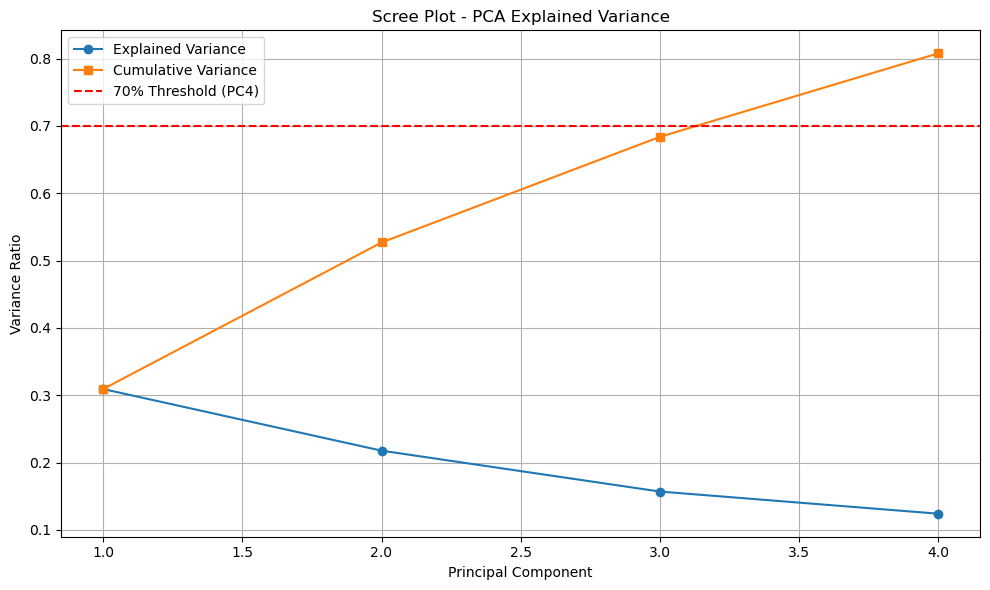

In [58]:
# Scree plot of PCA
plot_scree(pca, threshold=0.7)

In [59]:
top_loadings = get_top_pca_loadings(pca, imputed_df, top_n=10)

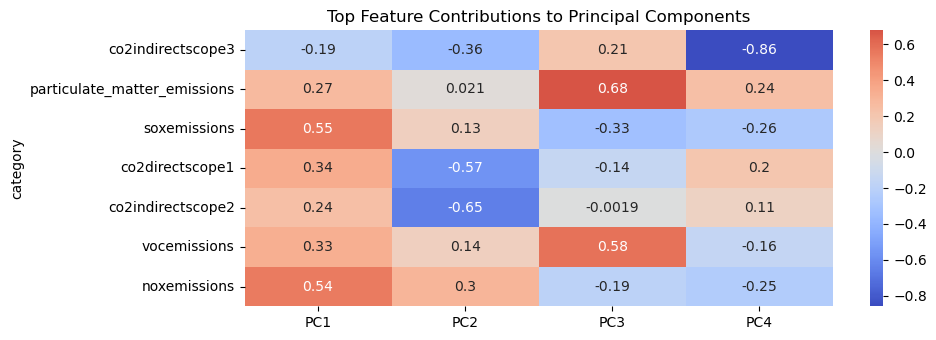

In [60]:
plot_pca_loadings_heatmap(top_loadings)       # Heatmap for multiple PCs

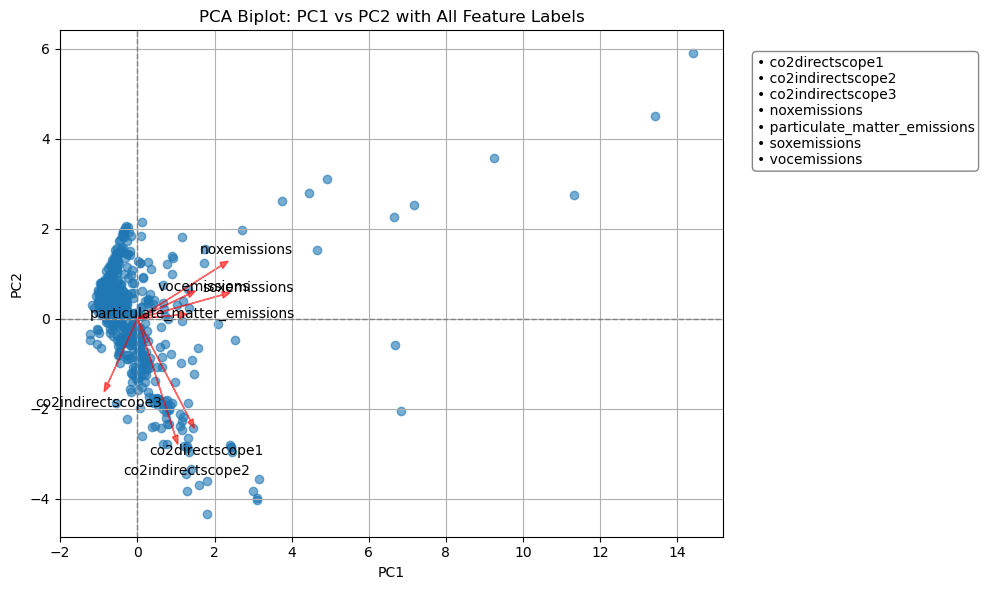

In [61]:
plot_biplot(pca, scores, imputed_df, arrow_scale=4, label_offset=1.3)

In [62]:
top_metrics = get_top_metric_categories(top_loadings, top_n=5, as_percent=True)

print("Top ESG categories for user selection:")
print(top_metrics)


Top ESG categories for user selection:
                         metric  importance_score importance_percent
0             co2indirectscope3          0.973385             18.54%
1  particulate_matter_emissions          0.769761             14.66%
2                  soxemissions          0.707057             13.47%
3               co2directscope1          0.706653             13.46%
4             co2indirectscope2          0.705471             13.44%
